In [ ]:
# !pip install scipy
# !pip install statsmodels

In [87]:
#from google.colab import files
import pandas as pd
import numpy as np
import calendar
# import warnings
from scipy.stats import spearmanr, kendalltau
from scipy.stats import entropy

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

#### Carga de archivos

In [206]:
# Cargamos el archivo Excel - RFF Procesado
# --------------

ruta_path = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS'               # -> Casa
# ruta_path = 'C:/Users/usuario/Documents/DOCUMENTOS_CONSULTOR_5_BI'      # -> Trabajo


ruta_path_fabrica = '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/df_sabana_fabrica_full.csv'
ruta_path_balanza = '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/df_sabana_participacion_full.csv'
ruta_path_saldo_campo = '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/df_sabana_saldo_campo_full_vf.csv'
ruta_calidad_precipitacion = '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/df_calidad_precipitacion_full.csv'
# --
ruta_calidad_racimos_propios = '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/df_calidad_racimos_propios_total_full.csv'
ruta_antiguedad_frutos = '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/df_antiguedad_fruta_full.csv'
# --
ruta_calidad_racimos_terceros = '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/df_sabana_calidad_terceros_full.csv'
# --
ruta_acidez = '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/df_acidez_full.csv'
# --
ruta_clima = '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/df_clima_full_vf.csv'
# --
ruta__freq_cosecha = '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/df_freq_cosecha_full.csv'
# --
ruta_participacion_cashcost_full = '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/df_participacion_cashcost_full.csv'
# --
ruta_perdida_aceite_full = '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/df_perdida_aceite_full.csv'







In [ ]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
fecha_limite = pd.Timestamp('2023-03-16')
df_filtrado = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi'][df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi']['FECHA'] > fecha_limite]

In [214]:
## FUNCION COMPLETITUD
## #######################
## #######################
## #######################

def function_completitud(df_x, variable, valor = 2, anio_filtro = '1901-01-01'):
    # Mostrando estadísticas importantes

    # --- Seleccionamos PLANTACION
    # ---
    df_bbdd_imputar = df_x
    plantacion_name = df_bbdd_imputar['PLANTACION'].unique()

    # Crear una nueva columna con el año y mes en el formato deseado
    df_bbdd_imputar['FECHA'] = pd.to_datetime(df_bbdd_imputar['FECHA'])

    # Crear un rango de fechas que cubra el período completo del DataFrame original
    start_date = df_bbdd_imputar['FECHA'].min().replace(day=1)
    end_date = (df_bbdd_imputar['FECHA'].max() + pd.offsets.MonthEnd(1)).replace(day=1) - pd.Timedelta(days=1)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Crear un DataFrame con todas las fechas
    df_all_dates = pd.DataFrame(all_dates, columns=['FECHA'])
    # Hacer un merge con el DataFrame original
    df_merged = pd.merge(df_all_dates, df_bbdd_imputar, on='FECHA', how='left')

    # Filtramos el año si es que fuera necesario
    # ---
    # Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
    fecha_limite = pd.Timestamp(anio_filtro)
    df_merged = df_merged[df_merged['FECHA'] > fecha_limite]

    # Crear las columnas variable_con_datos y variable_sin_datos
    df_merged['variable_con_datos'] = np.where(df_merged[variable].notnull() & (df_merged[variable] != 0), 1, 0)
    df_merged['variable_sin_datos'] = np.where(df_merged[variable].isnull() | (df_merged[variable] == 0), 1, 0)

    # Agrupar por mes y sumar las columnas
    df_merged['AÑO_MES'] = df_merged['FECHA'].dt.strftime('%Y-%m')
    df_monthly = df_merged.groupby('AÑO_MES').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_monthly['PLANTACION'] = plantacion_name[0]
    df_monthly['Total_dias'] = df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos']
    df_monthly['% Completitud'] = df_monthly['variable_con_datos']/(df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos'])

    # Agrupar por año
    df_merged['AÑO'] = df_merged['FECHA'].dt.strftime('%Y')
    df_year = df_merged.groupby('AÑO').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_year['PLANTACION'] = plantacion_name[0]
    df_year['Total_dias'] = df_year['variable_con_datos'] + df_year['variable_sin_datos']
    df_year['% Completitud'] = df_year['variable_con_datos']/(df_year['variable_con_datos'] + df_year['variable_sin_datos'])

    # Creando el indicador divergencia KL (Kullback-Leibler)
    # ------
    df_merged['incompleto'] = df_merged[variable]
    df_merged['completo'] = df_merged[variable]

    # Reemplazamos los ceros por NaN

    df_merged['completo'].replace(0, np.nan, inplace=True)
    df_merged['completo'].fillna(method='ffill', inplace=True) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular la moda de cada columna
    # moda_variable = df_merged['completo'].mode().iloc[0]

    # Verificar si la moda no está vacía antes de acceder al primer elemento
    if not df_merged['completo'].mode().empty:
        moda_variable = df_merged['completo'].mode().iloc[0]
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por la moda
    else:
        # Si no hay moda, calcular el promedio
        moda_variable = df_merged['completo'].mean()
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el promedio


    df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular las distribuciones de la variable original y la imputada
    hist_original, bin_edges = np.histogram(df_merged['incompleto'].dropna(), bins=30, density=True)
    hist_imputado, _ = np.histogram(df_merged['completo'], bins=bin_edges, density=True)

    # Calcular la divergencia KL entre las dos distribuciones
    kl_divergence = entropy(hist_original, hist_imputado)


    # Guardamos el datframe - df_monthly
    # -----
    print( "## ################# ##")
    print(f'Divergencia KL: {kl_divergence}')
    print(f'Dataframe creados: df_year, df_month')
    print( "## ################# ##")

    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_mensual =  '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_month.xlsx'  # Cambia esta ruta a la que necesites
    df_monthly.to_excel(ruta_path + ruta_missing_mensual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_mensual}')

    # Guardamos el datframe - df_year
    # -----
    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_anual =  '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_year.xlsx'  # Cambia esta ruta a la que necesites
    df_year.to_excel(ruta_path + ruta_missing_anual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_anual}')

     # Mostrar el DataFrame correspondiente según el valor de `val`
    if valor == 1:
        print("DataFrame df_year:")
        print(df_year.head(10))
    else:
        print("DataFrame df_month:")
        print(df_monthly.head(10))




## FUNCION GRAFICADORA 1
## #######################
## #######################
## #######################

def function_tendencia_unica(df_x, valor,colors='green'):
    df_x = df_x.sort_values(by='FECHA')
    plantacion_name = df_x['PLANTACION'].unique()

    plt.figure(figsize=(15, 5))
    plt.plot(df_x['FECHA'], df_x[valor], marker='o', markersize=2, linestyle='-', color=colors, label='Peso')
    plt.title(f'{plantacion_name[0]}: variable {valor} - por Día a través del Tiempo ')
    plt.xlabel('Fecha')
    plt.ylabel('Peso por Día')
    plt.grid(True)
    plt.legend()
    #plt.xticks(rotation=45)

    fecha_min = df_x['FECHA'].min()
    fecha_max = df_x['FECHA'].max()
    print('Analisis de ', fecha_min, ' hasta ', fecha_max)
    
    # Mostrar la gráfica
    # print(df_TEA_full_tendencia[df_TEA_full_tendencia['RFF PROCESADO'] == 0].head())
    plt.tight_layout()
    plt.show()





## FUNCION SAVE EXCEL
## #######################
## #######################
## #######################

def function_save(df_x):
    # Especifica la ruta donde deseas guardar el CSV
    ruta_save =  '/PROYECTO_001_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx'  # Cambia esta ruta a la que necesites
    df_x.to_excel(ruta_path + ruta_save, index=False)
    print(f'Datos guardados en {ruta_path + ruta_save}')



### Cargando datos processed

In [208]:
### Cargamos df_sabana_fabrica_full
### --------------------
df_sabana_fabrica_full = pd.read_csv(ruta_path + ruta_path_fabrica)
df_sabana_balanza_full = pd.read_csv(ruta_path + ruta_path_balanza)

df_sabana_saldo_campo_full_vf = pd.read_csv(ruta_path + ruta_path_saldo_campo)
df_sabana_saldo_campo_full_vf['FECHA'] = pd.to_datetime(df_sabana_saldo_campo_full_vf['FECHA'])

df_calidad_precipitacion_full = pd.read_csv(ruta_path + ruta_calidad_precipitacion)
df_calidad_precipitacion_full['FECHA'] = df_calidad_precipitacion_full['FECHA'].str.split(' ').str[0]
df_calidad_precipitacion_full['FECHA'] = pd.to_datetime(df_calidad_precipitacion_full['FECHA'], format='%Y-%m-%d')

# --
df_calidad_racimos_propios_full = pd.read_csv(ruta_path + ruta_calidad_racimos_propios)
df_calidad_antiguedad_frutos_full = pd.read_csv(ruta_path + ruta_antiguedad_frutos)

# --
df_sabana_calidad_terceros_full = pd.read_csv(ruta_path + ruta_calidad_racimos_terceros)
df_sabana_calidad_terceros_full['FECHA'] = pd.to_datetime(df_sabana_calidad_terceros_full['FECHA'], format='%Y-%m-%d')
df_sabana_calidad_terceros_full['% VERDES'] = df_sabana_calidad_terceros_full['% VERDES'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% MADUROS'] = df_sabana_calidad_terceros_full['% MADUROS'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% SMADUROS'] = df_sabana_calidad_terceros_full['% SMADUROS'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% ESCOBAJO'] = df_sabana_calidad_terceros_full['% ESCOBAJO'].replace('-',np.nan)

df_sabana_calidad_terceros_full['% VERDES'] = df_sabana_calidad_terceros_full['% VERDES'].astype(float)
df_sabana_calidad_terceros_full['% MADUROS'] = df_sabana_calidad_terceros_full['% MADUROS'].astype(float)
df_sabana_calidad_terceros_full['% SMADUROS'] = df_sabana_calidad_terceros_full['% SMADUROS'].astype(float)
df_sabana_calidad_terceros_full['% ESCOBAJO'] = df_sabana_calidad_terceros_full['% ESCOBAJO'].astype(float)

# --
df_acidez_full = pd.read_csv(ruta_path + ruta_acidez)

# --
df_clima_full_vf = pd.read_csv(ruta_path + ruta_clima)

# --
df_freq_cosecha_full = pd.read_csv(ruta_path + ruta__freq_cosecha)

# --
df_participacion_cashcost_full = pd.read_csv(ruta_path + ruta_participacion_cashcost_full)

# --
df_perdida_aceite_full = pd.read_csv(ruta_path + ruta_perdida_aceite_full)



### Visualizando datos/ completitud de datos

In [209]:
# df_sabana_fabrica_full.head(15)
# df_sabana_balanza_full.head()       # --> se actualizará con la data de Rolly (CashCost)

# df_sabana_saldo_campo_full_vf.head()

# print(df_calidad_precipitacion_full.dtypes)
# df_calidad_precipitacion_full.head()

# df_calidad_racimos_propios_full.head()
# df_calidad_antiguedad_frutos_full.head()

# df_acidez_full.head()
df_perdida_aceite_full.head()


,AÑO,MES,DIA,RFF PROCESADO,TM CONDENSADO,TM ACEITE CONDENSADO,% PERDIDA ACEITE CONDENSADO,TM ESCOBAJO SIN PICAR,TM ACEITE ESCOBAJO SIN PICAR,% PERDIDA ACEITE ESCOBAJO SIN PICAR,...,% PERDIDA ACEITE SOLIDO TD,TM ARENA,TM ACEITE EN ARENA,% PERDIDA ACEITE EN ARENA,TM NUEZ,TM ACEITE CASCARA,% PERDIDA ACEITE EN CASCARA,% PERDIDA TOTAL,PLANTACION,FECHA
0,2024,Enero,2024-01-01 00:00:00,0.00000,0.000000,0.000000,-,0.000000,0.000000,-,...,-,0.000000,0.000000,-,0.000000,0.000000,-,-,Nuevo Horizonte,2024-01-01
1,2024,Enero,2024-01-02 00:00:00,302.26061,19.042418,0.238901,0.0007903808571020882,52.895607,2.382416,0.007881992959651607,...,0.002220726015209193,0.634747,0.057962,0.0001917616721543704,21.158243,0.106710,0.0003530397162898599,0.0202568670790415,Nuevo Horizonte,2024-01-02
2,2024,Enero,2024-01-03 00:00:00,338.41343,21.320046,0.258341,0.0007633887343064369,59.222350,3.375230,0.009973688100971644,...,0.002029130463291602,0.710668,0.027868,8.234897769866876e-05,23.688940,0.165019,0.0004876254467796978,0.02696437904370403,Nuevo Horizonte,2024-01-03
3,2024,Enero,2024-01-04 00:00:00,236.91708,14.925776,0.070097,0.0002958714500448849,41.460489,2.362937,0.009973687840488327,...,0.001734442278285719,0.497526,0.033217,0.000140205172206242,16.584196,0.107534,0.0004538887614181299,0.02292621536615258,Nuevo Horizonte,2024-01-04
4,2024,Enero,2024-01-05 00:00:00,264.46554,16.661329,0.075064,0.0002838328199583205,46.281470,2.637697,0.009973688821613584,...,0.001735462397104742,0.555378,0.067796,0.0002563509786568035,18.512588,0.124013,0.0004689193155372908,0.02419812426223848,Nuevo Horizonte,2024-01-05


In [ ]:
df_sabana_fabrica_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                  'MES_NRO':'count'})

In [ ]:
df_sabana_balanza_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                  'PTANIO':'count'})

In [ ]:
df_sabana_saldo_campo_full_vf.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                        'SALDO':'count'})

In [ ]:
df_calidad_precipitacion_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                         'PLANTACION':'count'})

In [5]:
df_calidad_racimos_propios_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                           'PLANTACION':'count'})

FECHA             PLANTACION
                        min         max      count
PLANTACION                                        
Nuevo Horizonte  2022-01-03  2024-07-06        717
Palmawasi        2021-08-18  2024-07-06        853
Shanuzi          2022-01-03  2024-07-01        787

In [ ]:
df_calidad_antiguedad_frutos_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                             'PLANTACION':'count'})

In [ ]:
df_sabana_calidad_terceros_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                           'PLANTACION':'count'})

In [ ]:
df_acidez_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                          'PLANTACION':'count'})

In [ ]:
df_clima_full_vf.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                            'PLANTACION':'count'})

In [ ]:
df_freq_cosecha_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                'PLANTACION':'count'})

In [ ]:
df_participacion_cashcost_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                          'PLANTACION':'count'})

In [210]:
df_perdida_aceite_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                  'PLANTACION':'count'})

FECHA             PLANTACION
                        min         max      count
PLANTACION                                        
Nuevo Horizonte  2023-01-01  2024-12-31        731
Palmawasi        2023-01-01  2024-07-15        562
Shanuzi          2021-01-01  2024-12-31       1461
Tulumayo         2022-01-01  2024-12-31       1096

##### --------------------------------------------

In [212]:
df_perdida_aceite_full.groupby('PLANTACION').size()

PLANTACION
Nuevo Horizonte     731
Palmawasi           562
Shanuzi            1461
Tulumayo           1096
dtype: int64

In [221]:
function_completitud(df_perdida_aceite_full[df_perdida_aceite_full['PLANTACION'] == 'Nuevo Horizonte'],'TM ACEITE CONDENSADO',1,'2024-01-01')

## ################# ##
Divergencia KL: 1.9236119421852924
Dataframe creados: df_year, df_month
## ################# ##
Datos guardados en C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_001_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_month.xlsx
Datos guardados en C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_001_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_year.xlsx
DataFrame df_year:
    AÑO  variable_con_datos  variable_sin_datos       PLANTACION  Total_dias  \
0  2024                 153                 212  Nuevo Horizonte         365   

   % Completitud  
0       0.419178  


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21656\88931506.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bbdd_imputar['FECHA'] = pd.to_datetime(df_bbdd_imputar['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21656\88931506.py:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the o

In [ ]:
# df_sabana_fabrica_full.groupby('PLANTACION').size()
# df_sabana_balanza_full.groupby('PLANTACION').size()
# df_sabana_saldo_campo_full_vf.groupby('PLANTACION').size()
# df_calidad_precipitacion_full.groupby('PLANTACION').size()


##### Transformando datos

In [ ]:
# AÑADIENDO DATOS DE BALANZA Y FABRICA
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full = pd.merge(df_sabana_balanza_full[['FECHA','PLANTACION','PROPIOS','TERCEROS','TOTAL','PARTICIPACION CP']], 
                       df_sabana_fabrica_full[['FECHA','PLANTACION','RFF PROCESADO','CPO OBTENIDO','TEA']], 
                       on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_TEA_full['FECHA'] = pd.to_datetime(df_TEA_full['FECHA'])


print(f'df_sabana_balanza_full: {df_sabana_balanza_full.shape}')
print(f'df_sabana_fabrica_full: {df_sabana_fabrica_full.shape}')

print(df_TEA_full['PLANTACION'].unique())
print(f'df_TEA_full: {df_TEA_full.shape}')
df_TEA_full.head(15)

In [ ]:
# AÑADIENDO DATOS DE PRECIPITACION
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full = pd.merge(df_TEA_full, 
                       df_calidad_precipitacion_full, 
                       on=['FECHA', 'PLANTACION'], how='outer')

# Convertir 'FECHA' a formato datetime
df_TEA_full['FECHA'] = pd.to_datetime(df_TEA_full['FECHA'])

print(df_TEA_full['PLANTACION'].unique())
print(f'df_TEA_full: {df_TEA_full.shape}')
df_TEA_full.head(15)

In [ ]:
function_tendencia_unica(df_TEA_full[df_TEA_full['PLANTACION'] == 'Palmawasi'], 'TERCEROS')

In [ ]:
# AÑADIENDO DATOS DE CALIDAD RACIMOS PROPIOS
# #######################
# #######################

df_calidad_racimos_propios_full.tail()
# df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi'].tail(15)


In [ ]:
df_calidad_racimos_propios_full_group = df_calidad_racimos_propios_full.groupby(['FECHA','PLANTACION','SECTOR']).agg({'VERDES':'sum',
                                                                                                                      'MADUROS':'sum',
                                                                                                                      'SMADUROS':'sum',
                                                                                                                      'PEDUNCULO':'sum',
                                                                                                                      'ESCOBAJO':'sum',
                                                                                                                      'MALFORMADOA':'sum',
                                                                                                                      'MALFORMADOB': 'sum',
                                                                                                                      'Peso':'sum',
                                                                                                                      'Racimos':'sum'}).reset_index()

# Validamos presencia de duplicados en la bbdd
df_prueba = df_calidad_racimos_propios_full[['FECHA','PLANTACION','SECTOR']].drop_duplicates()
print(df_calidad_racimos_propios_full.shape)
print(df_prueba.shape)

# Creando variables de calidad
df_calidad_racimos_propios_full_group['Peso_CALIDAD'] = df_calidad_racimos_propios_full_group[['VERDES','MADUROS','SMADUROS','PEDUNCULO','ESCOBAJO']].sum(axis=1)

df_calidad_racimos_propios_full_group['Peso_VERDES'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['VERDES']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_MADUROS'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['MADUROS']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_SMADUROS'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['SMADUROS']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_PEDUNCULO'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['PEDUNCULO']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_ESCOBAJO'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['ESCOBAJO']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])

# print(df_calidad_racimos_propios_full_group['PLANTACION'].unique())

# Craendo dataframe agrupando los sectores
# ------------
df_agg_racimos = df_calidad_racimos_propios_full_group.groupby(['FECHA','PLANTACION']).agg({'Peso_VERDES':'sum',
                                                                                            'Peso_MADUROS':'sum',
                                                                                            'Peso_SMADUROS':'sum',
                                                                                            'Peso_PEDUNCULO':'sum',
                                                                                            'Peso_ESCOBAJO':'sum',
                                                                                            'Peso':'sum',
                                                                                            'Racimos':'sum'}).reset_index()
df_agg_racimos['FECHA'] = pd.to_datetime(df_agg_racimos['FECHA'])

print(df_agg_racimos['PLANTACION'].unique())
df_agg_racimos.tail()


In [ ]:
# AÑADIENDO DATOS DE PRECIPITACION
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full = pd.merge(df_TEA_full, 
                       df_agg_racimos, 
                       on=['FECHA', 'PLANTACION'], how='outer')

# Convertir 'FECHA' a formato datetime
df_TEA_full['FECHA'] = pd.to_datetime(df_TEA_full['FECHA'])

print(df_TEA_full['PLANTACION'].unique())
print(f'df_TEA_full: {df_TEA_full.shape}')
df_TEA_full.head()

In [ ]:
function_tendencia_unica(df_agg_racimos[df_agg_racimos['PLANTACION'] == 'Palmawasi'], 'Peso')

#### Analizando tendencias

##### ACIDEZ VS CALIDAD RACIMOS PROPIOS

In [6]:
df_acidez_full.head()

,FECHA,PLANTACION,% Acidez
0,2024-01-01,Nuevo Horizonte,NaN
1,2024-01-02,Nuevo Horizonte,2.4050
2,2024-01-02,Palmawasi,2.0125
3,2024-01-02,Tulumayo,2.8700
4,2024-01-03,Nuevo Horizonte,1.9900


In [7]:
df_acidez_full.PLANTACION.unique()

array(['Nuevo Horizonte', 'Palmawasi', 'Tulumayo', 'Shanuzi'],
      dtype=object)

In [8]:
df_acidez_full[df_acidez_full['PLANTACION'] == 'Shanuzi'].tail()

,FECHA,PLANTACION,% Acidez
1396,2024-07-05,Shanuzi,3.18
1397,2024-07-06,Shanuzi,3.16
1398,2024-07-07,Shanuzi,3.08
1399,2024-07-08,Shanuzi,3.24
1400,2024-07-09,Shanuzi,3.18


Analisis de  2022-01-01  hasta  2024-07-09


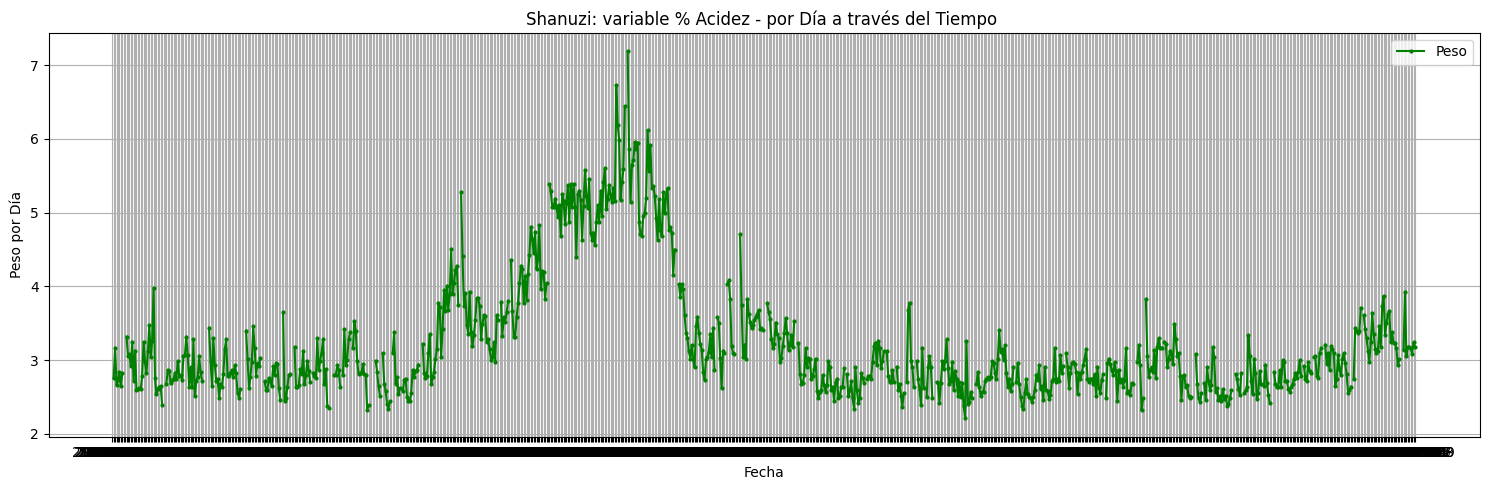

In [9]:
function_tendencia_unica(df_acidez_full[df_acidez_full['PLANTACION'] == 'Shanuzi'], '% Acidez')

In [10]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia = df_acidez_full[df_acidez_full['PLANTACION'] == 'Shanuzi']
df_analisis_tendencia['FECHA'] = pd.to_datetime(df_analisis_tendencia['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_tendencia.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21656\114239547.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['FECHA'] = pd.to_datetime(df_analisis_tendencia['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21656\114239547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,% Acidez,SEMANA
485,2022-01-01,Shanuzi,NaN,2021-12-27
486,2022-01-02,Shanuzi,2.76,2021-12-27
487,2022-01-03,Shanuzi,3.17,2022-01-03
488,2022-01-04,Shanuzi,2.66,2022-01-03
489,2022-01-05,Shanuzi,2.73,2022-01-03


In [11]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_tendencia_semana = df_analisis_tendencia.groupby(['SEMANA','PLANTACION']).agg({'% Acidez': 'mean'}).reset_index()
df_analisis_tendencia_semana.columns = ['FECHA','PLANTACION','% Acidez']
df_analisis_tendencia_semana.head()

,FECHA,PLANTACION,% Acidez
0,2021-12-27,Shanuzi,2.760000
1,2022-01-03,Shanuzi,2.811667
2,2022-01-10,Shanuzi,3.058333
3,2022-01-17,Shanuzi,2.801429
4,2022-01-24,Shanuzi,3.237143


Analisis de  2021-12-27 00:00:00  hasta  2024-07-08 00:00:00


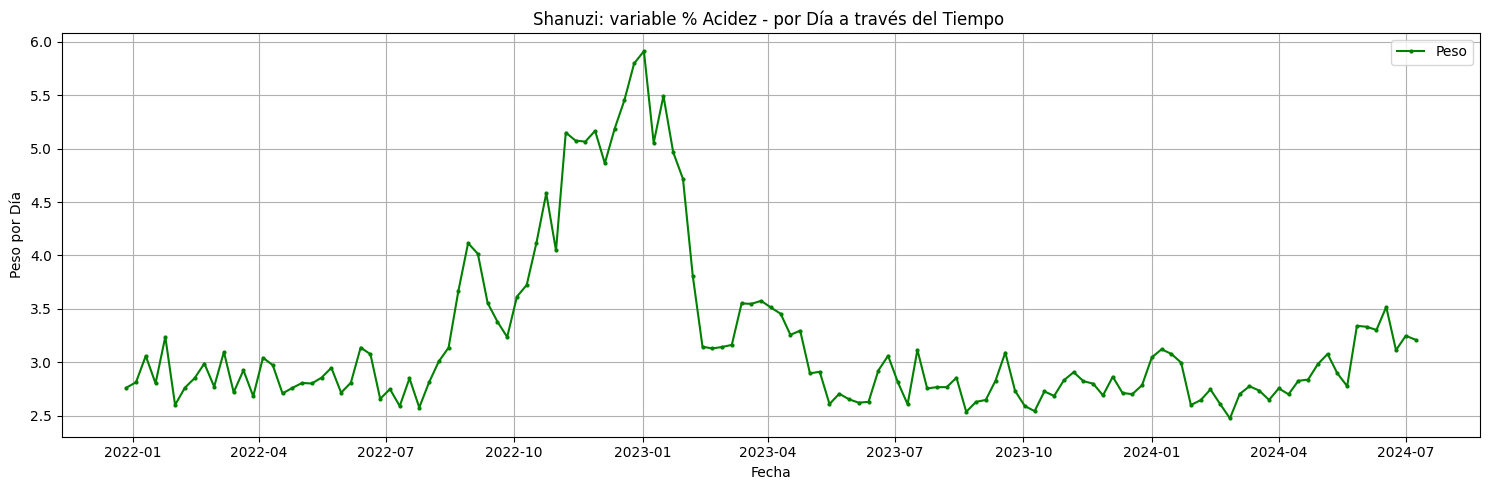

In [12]:
function_tendencia_unica(df_analisis_tendencia_semana, '% Acidez')

Calidad racimos propios

In [13]:
df_calidad_racimos_propios_full.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN


In [16]:
df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi'].tail()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos
2334,2024-06-25,Shanuzi,1.0,3489.0,186.0,0.0,89.0,157.0,44.0,45965.591774,36234.0
2337,2024-06-26,Shanuzi,11.0,2373.0,164.0,8.0,30.0,136.0,35.0,49590.205259,41614.0
2340,2024-06-27,Shanuzi,1.0,2119.0,151.0,6.0,22.0,118.0,13.0,52778.939797,39052.0
2343,2024-06-28,Shanuzi,1.0,2050.0,164.0,4.0,4.0,109.0,21.0,41173.740164,28613.0
2348,2024-07-01,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26132.334681,12906.0


In [47]:
function_save(df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi'])

Datos guardados en C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_001_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx


In [15]:
df_calidad_racimos_propios_full.PLANTACION.unique()

array(['Palmawasi', 'Nuevo Horizonte', 'Shanuzi'], dtype=object)

In [17]:
# Creando variables de calidad
df_calidad_racimos_propios_full['Peso_CALIDAD'] = df_calidad_racimos_propios_full[['VERDES','MADUROS','SMADUROS','ESCOBAJO']].sum(axis=1)

df_calidad_racimos_propios_full['Peso_VERDES'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['VERDES']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])
df_calidad_racimos_propios_full['Peso_MADUROS'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['MADUROS']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])
df_calidad_racimos_propios_full['Peso_SMADUROS'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['SMADUROS']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])
df_calidad_racimos_propios_full['Peso_ESCOBAJO'] = df_calidad_racimos_propios_full['Peso']*(df_calidad_racimos_propios_full['ESCOBAJO']/ df_calidad_racimos_propios_full['Peso_CALIDAD'])

df_calidad_racimos_propios_full.head()


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN,2095.0,NaN,NaN,NaN,NaN
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN,2282.0,NaN,NaN,NaN,NaN
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN,1903.0,NaN,NaN,NaN,NaN
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN,2181.0,NaN,NaN,NaN,NaN
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN,1452.0,NaN,NaN,NaN,NaN


In [50]:
df_calidad_racimos_propios_full['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_full['FECHA'])

In [51]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
fecha_limite = pd.Timestamp('2023-03-16')
df_filtrado = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi'][df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi']['FECHA'] > fecha_limite]

Analisis de  2023-03-17 00:00:00  hasta  2024-07-01 00:00:00


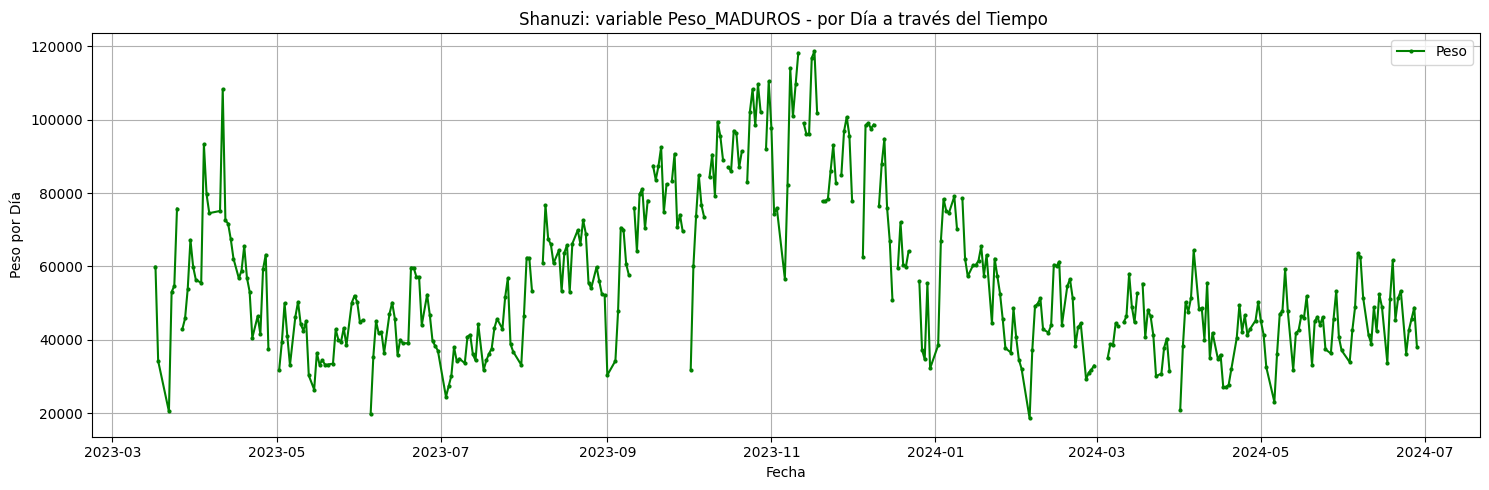

In [52]:
function_tendencia_unica(df_filtrado,'Peso_MADUROS')

Analisis de  2021-12-27 00:00:00  hasta  2024-07-08 00:00:00


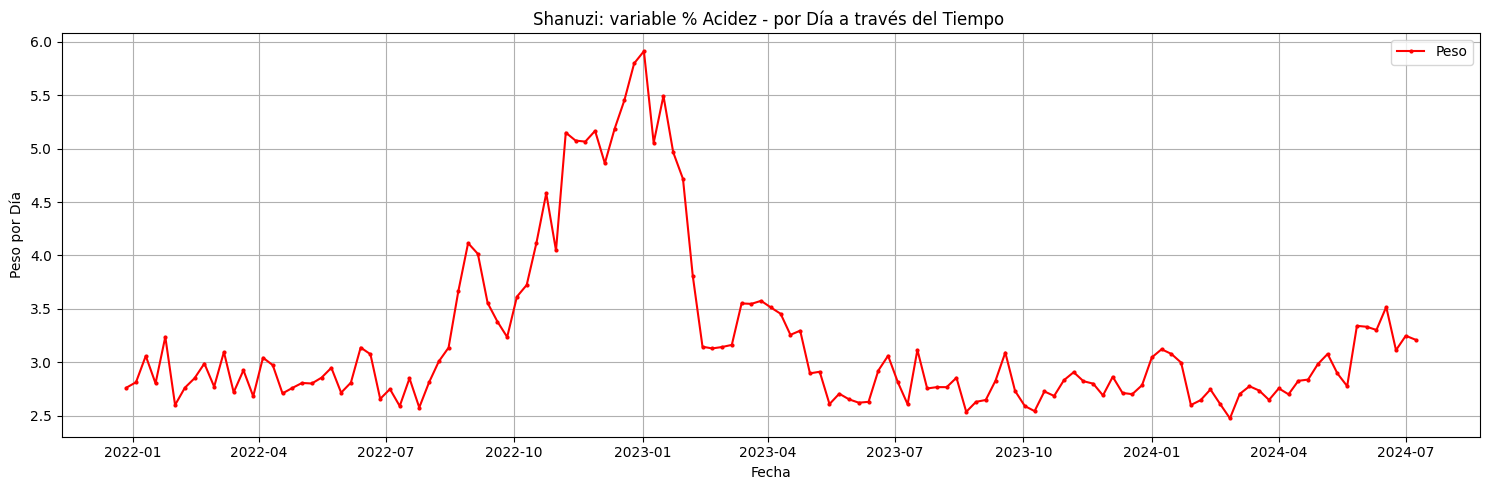

In [36]:
function_tendencia_unica(df_analisis_tendencia_semana, '% Acidez','red')

In [40]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia_2 = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi']
df_analisis_tendencia_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_2['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2['SEMANA'] = df_analisis_tendencia_2['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_tendencia_2.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21656\3552938210.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_2['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21656\3552938210.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2['SEMANA'] = df_analisis_tendencia_2['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,SEMANA
56,2022-01-03,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31175.552004,55872.0,0.0,NaN,NaN,NaN,NaN,2022-01-03
59,2022-01-04,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76380.078096,71622.0,0.0,NaN,NaN,NaN,NaN,2022-01-03
62,2022-01-05,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77042.863229,74650.0,0.0,NaN,NaN,NaN,NaN,2022-01-03
65,2022-01-06,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84379.408620,74774.0,0.0,NaN,NaN,NaN,NaN,2022-01-03
68,2022-01-07,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70109.531511,60555.0,0.0,NaN,NaN,NaN,NaN,2022-01-03


In [31]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_tendencia_semana_2 = df_analisis_tendencia_2.groupby(['SEMANA','PLANTACION']).agg({'Peso': 'sum',
                                                                                             'Racimos':'sum',
                                                                                             'Peso_CALIDAD':'sum',
                                                                                             'Peso_VERDES':'sum',
                                                                                             'Peso_MADUROS':'sum',
                                                                                             'Peso_SMADUROS':'sum',
                                                                                             'Peso_ESCOBAJO':'sum'}).reset_index()

df_analisis_tendencia_semana_2.columns = ['FECHA', 'PLANTACION', 'Peso', 'Racimos', 'Peso_CALIDAD','Peso_VERDES', 'Peso_MADUROS', 'Peso_SMADUROS', 'Peso_ESCOBAJO']
df_analisis_tendencia_semana_2.tail()

,FECHA,PLANTACION,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO
126,2024-06-03,Shanuzi,334119.271700,209760.0,21869.0,161.186587,303161.642878,24734.459199,6061.983036
127,2024-06-10,Shanuzi,301237.172671,215799.0,16687.0,493.550926,272941.793024,21097.055804,6704.772917
128,2024-06-17,Shanuzi,319960.561632,210852.0,16602.0,244.326058,296665.154177,17974.075640,5077.005757
129,2024-06-24,Shanuzi,228757.431081,174316.0,13520.0,324.286548,211284.487070,14786.585342,2362.072121
130,2024-07-01,Shanuzi,26132.334681,12906.0,0.0,0.000000,0.000000,0.000000,0.000000


In [53]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
fecha_limite = pd.Timestamp('2023-03-16')
df_filtrado_2 = df_analisis_tendencia_semana_2[df_analisis_tendencia_semana_2['FECHA'] > fecha_limite]

Analisis de  2023-03-20 00:00:00  hasta  2024-07-01 00:00:00


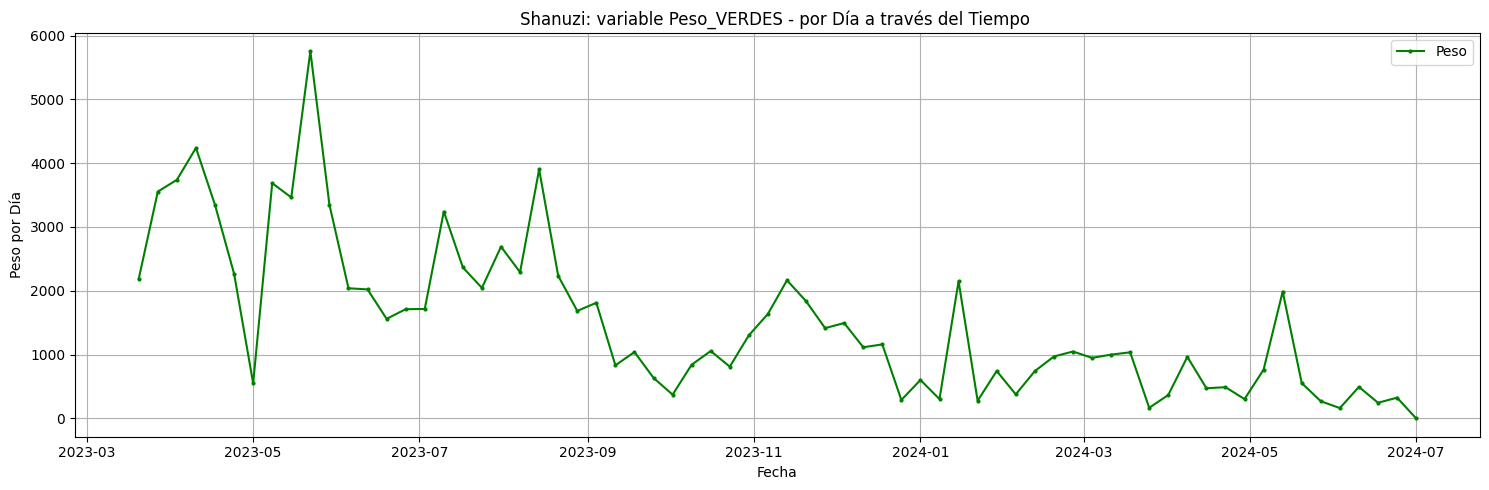

In [130]:
function_tendencia_unica(df_filtrado_2,'Peso_VERDES')
# function_tendencia_unica(df_filtrado_2,'Peso_MADUROS')
# function_tendencia_unica(df_filtrado_2,'Peso_SMADUROS')



In [59]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
fecha_limite = pd.Timestamp('2023-03-16')
df_filtrado_3 = df_analisis_tendencia_semana[df_analisis_tendencia_semana['FECHA'] > fecha_limite]

Analisis de  2023-03-20 00:00:00  hasta  2024-07-08 00:00:00


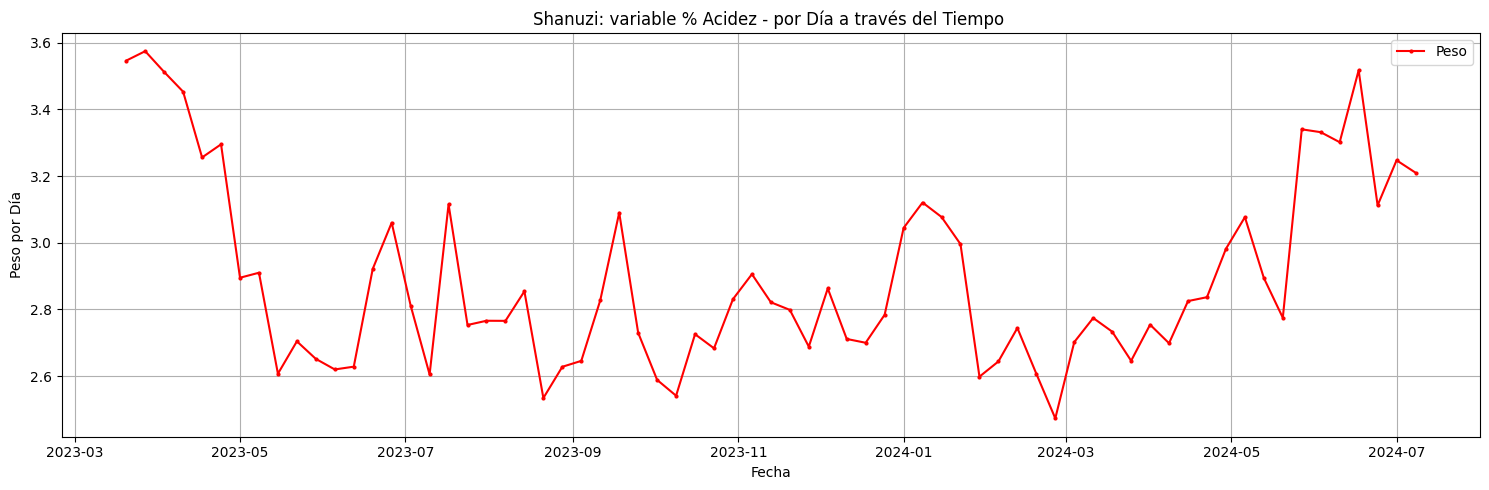

In [61]:
function_tendencia_unica(df_filtrado_3, '% Acidez','red')

In [62]:
df_filtrado_3.head()

,FECHA,PLANTACION,% Acidez
64,2023-03-20,Shanuzi,3.546000
65,2023-03-27,Shanuzi,3.574286
66,2023-04-03,Shanuzi,3.512000
67,2023-04-10,Shanuzi,3.452857
68,2023-04-17,Shanuzi,3.255714


In [63]:
df_filtrado_2.head()

,FECHA,PLANTACION,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO
63,2023-03-20,Shanuzi,248347.409141,155271.0,10889.0,2189.188982,203982.933726,33605.579915,0.000000
64,2023-03-27,Shanuzi,399356.911393,298517.0,13394.0,3554.033259,326356.547976,69446.330159,0.000000
65,2023-04-03,Shanuzi,366593.305232,212737.0,9958.0,3738.517019,302985.791155,59868.997058,0.000000
66,2023-04-10,Shanuzi,555481.370537,315666.0,17797.0,4238.635095,457392.058714,87408.343341,6442.333387
67,2023-04-17,Shanuzi,417125.171151,329493.0,18654.0,3343.661864,331907.235121,76676.425463,5197.848704


In [66]:
# AÑADIENDO DATOS DE BALANZA Y FABRICA
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_full = pd.merge(df_filtrado_3,
                            df_filtrado_2,
                            on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_analisis_full['FECHA'] = pd.to_datetime(df_analisis_full['FECHA'])
df_analisis_full.head()

,FECHA,PLANTACION,% Acidez,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO
0,2023-03-20,Shanuzi,3.546000,248347.409141,155271.0,10889.0,2189.188982,203982.933726,33605.579915,0.000000
1,2023-03-27,Shanuzi,3.574286,399356.911393,298517.0,13394.0,3554.033259,326356.547976,69446.330159,0.000000
2,2023-04-03,Shanuzi,3.512000,366593.305232,212737.0,9958.0,3738.517019,302985.791155,59868.997058,0.000000
3,2023-04-10,Shanuzi,3.452857,555481.370537,315666.0,17797.0,4238.635095,457392.058714,87408.343341,6442.333387
4,2023-04-17,Shanuzi,3.255714,417125.171151,329493.0,18654.0,3343.661864,331907.235121,76676.425463,5197.848704


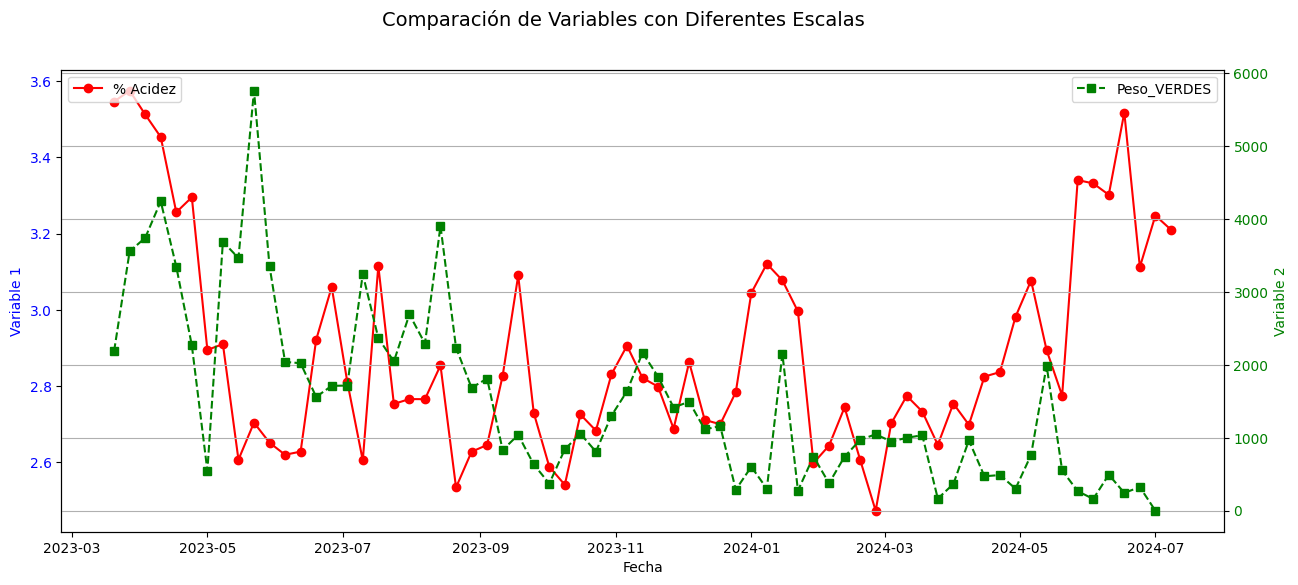

In [131]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez'], color='red', marker='o', linestyle='-', label='% Acidez')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES'], color='green', marker='s', linestyle='--', label='Peso_VERDES')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS'], color='green', marker='s', linestyle='--', label='Peso_MADUROS')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle('Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [142]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full['% Acidez_rolling_2'] = df_analisis_full['% Acidez'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['% Acidez_rolling_3'] = df_analisis_full['% Acidez'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['% Acidez_rolling_4'] = df_analisis_full['% Acidez'].rolling(window=3).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_SMADUROS_rolling_2'] = df_analisis_full['Peso_SMADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_SMADUROS_rolling_3'] = df_analisis_full['Peso_SMADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_SMADUROS_rolling_4'] = df_analisis_full['Peso_SMADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_MADUROS_rolling_2'] = df_analisis_full['Peso_MADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_MADUROS_rolling_3'] = df_analisis_full['Peso_MADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_MADUROS_rolling_4'] = df_analisis_full['Peso_MADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos


df_analisis_full['Peso_VERDES_rolling_2'] = df_analisis_full['Peso_VERDES'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_VERDES_rolling_3'] = df_analisis_full['Peso_VERDES'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_VERDES_rolling_4'] = df_analisis_full['Peso_VERDES'].rolling(window=4).mean() # Suavizado a 4 periodos
df_analisis_full['Peso_VERDES_rolling_5'] = df_analisis_full['Peso_VERDES'].rolling(window=5).mean() # Suavizado a 4 periodos



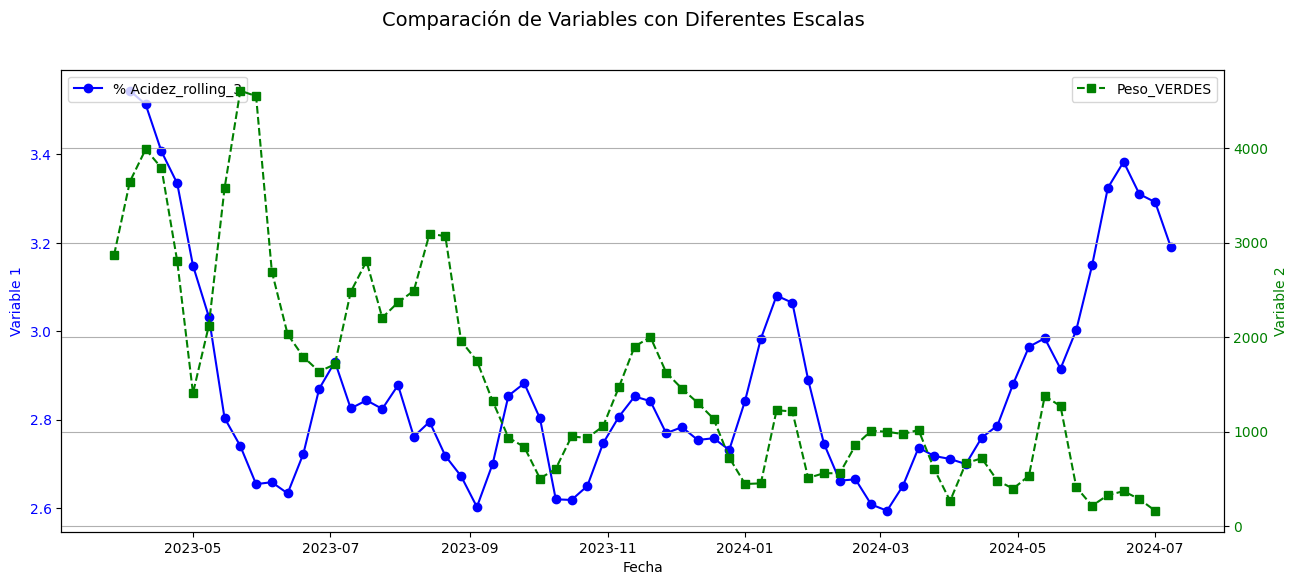

In [157]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

# Graficar la primera variable en el eje principal
#ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez'], color='blue', marker='o', linestyle='-', label='% Acidez')
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez_rolling_3'], color='blue', marker='o', linestyle='-', label='% Acidez_rolling_3')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
#ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES'], color='green', marker='s', linestyle='--', label='Peso_VERDES')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES'], color='green', marker='s', linestyle='--', label='Peso_MADUROS')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS_rolling_2')

# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MADUROS_rolling_2')

ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_VERDES')


ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle('Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [164]:
# df_analisis_full['% Acidez_rolling_3'].corr(df_analisis_full['Peso_SMADUROS_rolling_2'])

# df_analisis_full['% Acidez'].corr(df_analisis_full['Peso_SMADUROS'])
df_analisis_full['% Acidez'].corr(df_analisis_full['Peso_MADUROS'])
# df_analisis_full['% Acidez_rolling_3'].corr(df_analisis_full['Peso_VERDES'])



-0.06962343234295118

In [152]:
def correlacion_cruzada(serie1, serie2):
    lags = np.arange(-len(serie1) + 1, len(serie1))
    corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
    return lags, corr

lags, corr = correlacion_cruzada(df_analisis_full['% Acidez_rolling_3'], df_analisis_full['Peso_VERDES'])

c:\Users\CESAR QUEZADA\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\CESAR QUEZADA\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\CESAR QUEZADA\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [128]:
lags, corr

(array([-68, -67, -66, -65, -64, -63, -62, -61, -60, -59, -58, -57, -56,
        -55, -54, -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43,
        -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30,
        -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17,
        -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,
         -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
         10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
         23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
         36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  64,  65,  66,  67,  68]),
 [nan,
  nan,
  nan,
  nan,
  1.0,
  0.9984438861752605,
  0.8884924344622653,
  0.8573166730041405,
  0.6251368081045531,
  0.6125355012075125,
  0.47303428941306747,
  0.3349475731488265,
  0.1852079366672609,
  0.066930780

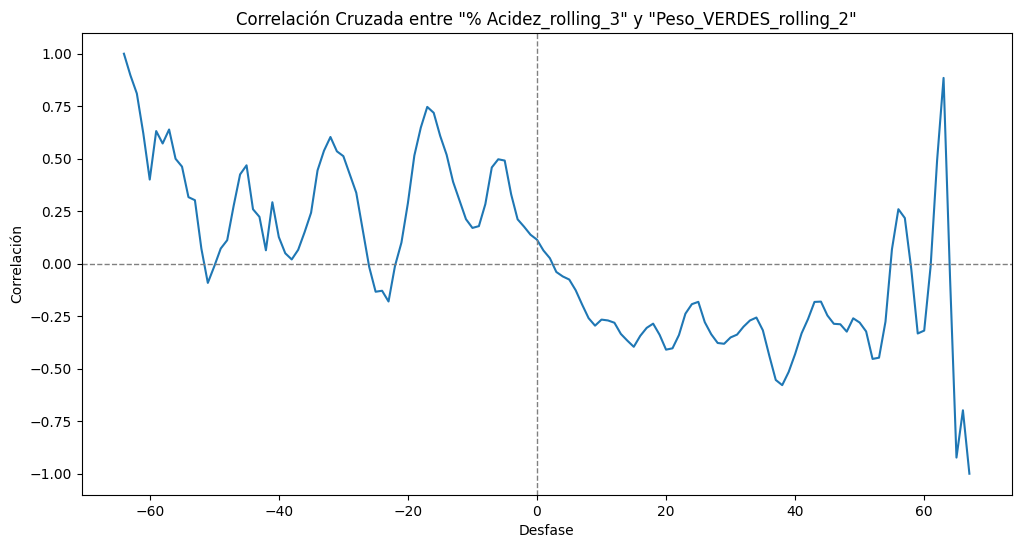

In [153]:
# Graficar correlación cruzada
plt.figure(figsize=(12, 6))
plt.plot(lags, corr)
plt.title('Correlación Cruzada entre "% Acidez_rolling_3" y "Peso_VERDES_rolling_2"')
plt.xlabel('Desfase')
plt.ylabel('Correlación')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()

In [75]:
# Probando traslaciones temporales
# -----------

# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full['% Acidez_SHIFTED_1'] = df_analisis_full['% Acidez'].shift(-1)
df_analisis_full['% Acidez_SHIFTED_2'] = df_analisis_full['% Acidez'].shift(-2)
df_analisis_full['% Acidez_SHIFTED_3'] = df_analisis_full['% Acidez'].shift(-3)
df_analisis_full['% Acidez_SHIFTED_4'] = df_analisis_full['% Acidez'].shift(-4)
df_analisis_full['% Acidez_SHIFTED_5'] = df_analisis_full['% Acidez'].shift(-5)
df_analisis_full['% Acidez_SHIFTED_6'] = df_analisis_full['% Acidez'].shift(-6)
df_analisis_full['% Acidez_SHIFTED_7'] = df_analisis_full['% Acidez'].shift(-7)

df_analisis_full.head()

,FECHA,PLANTACION,% Acidez,Peso,Racimos,Peso_CALIDAD,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,% Acidez_SHIFTED_1,% Acidez_SHIFTED_2,% Acidez_SHIFTED_3,% Acidez_SHIFTED_4,% Acidez_SHIFTED_5,% Acidez_SHIFTED_6,% Acidez_SHIFTED_7
0,2023-03-20,Shanuzi,3.546000,248347.409141,155271.0,10889.0,2189.188982,203982.933726,33605.579915,0.000000,3.574286,3.512000,3.452857,3.255714,3.295000,2.895000,2.910000
1,2023-03-27,Shanuzi,3.574286,399356.911393,298517.0,13394.0,3554.033259,326356.547976,69446.330159,0.000000,3.512000,3.452857,3.255714,3.295000,2.895000,2.910000,2.607143
2,2023-04-03,Shanuzi,3.512000,366593.305232,212737.0,9958.0,3738.517019,302985.791155,59868.997058,0.000000,3.452857,3.255714,3.295000,2.895000,2.910000,2.607143,2.704286
3,2023-04-10,Shanuzi,3.452857,555481.370537,315666.0,17797.0,4238.635095,457392.058714,87408.343341,6442.333387,3.255714,3.295000,2.895000,2.910000,2.607143,2.704286,2.651667
4,2023-04-17,Shanuzi,3.255714,417125.171151,329493.0,18654.0,3343.661864,331907.235121,76676.425463,5197.848704,3.295000,2.895000,2.910000,2.607143,2.704286,2.651667,2.620000


In [74]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_analisis_full['% Acidez'].corr(df_analisis_full['Peso_MADUROS'], method='pearson')
correlation_spearman = df_analisis_full['% Acidez'].corr(df_analisis_full['Peso_MADUROS'], method='spearman')
correlation_kendall = df_analisis_full['% Acidez'].corr(df_analisis_full['Peso_MADUROS'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)

Correlación de Pearson: -0.06962343234295118
Correlación de Spearman: 0.04149369673908014
Correlación de Kendall: 0.025905598867978975


In [83]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_analisis_full['% Acidez_SHIFTED_4'].corr(df_analisis_full['Peso_MADUROS'], method='pearson')
correlation_spearman = df_analisis_full['% Acidez_SHIFTED_4'].corr(df_analisis_full['Peso_MADUROS'], method='spearman')
correlation_kendall = df_analisis_full['% Acidez_SHIFTED_4'].corr(df_analisis_full['Peso_MADUROS'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)

Correlación de Pearson: -0.07172678209377874
Correlación de Spearman: -0.005922267507647105
Correlación de Kendall: -0.01009858168166956


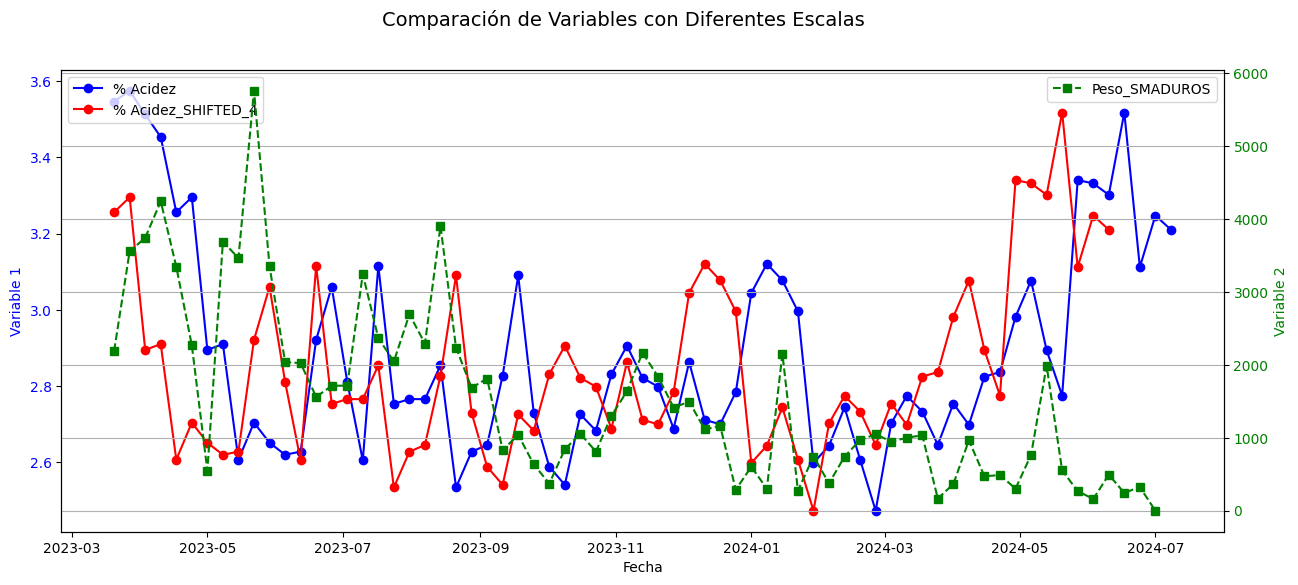

In [82]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez'], color='blue', marker='o', linestyle='-', label='% Acidez')
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez_SHIFTED_4'], color='red', marker='o', linestyle='-', label='% Acidez_SHIFTED_4')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
#ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES'], color='green', marker='s', linestyle='--', label='Peso_VERDES')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES'], color='green', marker='s', linestyle='--', label='Peso_MADUROS')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle('Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [84]:
# Datos de ejemplo
toneladas = np.array([100, 200, 300, 400, 500])
porcentajes = np.array([10, 20, 30, 40, 50])

In [90]:
# Normalización (escalado)
toneladas_norm = (df_analisis_full['Peso_VERDES'] - np.mean(df_analisis_full['Peso_VERDES'])) / np.std(df_analisis_full['Peso_VERDES'])
porcentajes_norm = (df_analisis_full['% Acidez'] - np.mean(df_analisis_full['% Acidez'])) / np.std(df_analisis_full['% Acidez'])

In [91]:
# Calcular la correlación de Pearson
correlacion, _ = pearsonr(toneladas_norm, porcentajes_norm)
print(f'Correlación de Pearson: {correlacion}')

Correlación de Pearson: nan


In [89]:
# Calcular la correlación de Pearson
correlacion, _ = pearsonr(toneladas, porcentajes)
print(f'Correlación de Pearson: {correlacion}')

Correlación de Pearson: 0.9999999999999998


##### PROPORCION DE PARTICIPACION PROPIOS Y TERCEROS

In [166]:
df_participacion_cashcost_full.head()

,pk_tiempo,vch_centro,SEDE,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,CPOObtenidoPropios,CPOObtenidoTerceros,FECHA,PLANTACION
0,20190101,3002,PW,0.00,0.00,0.00,0.00,0.00000,0.00000,2019-01-01,Palmawasi
1,20190102,3002,PW,496.30,406.32,89.98,122.00,109.11564,12.88436,2019-01-02,Palmawasi
2,20190102,3006,NH,121.80,0.00,121.80,31.09,4.53060,26.55940,2019-01-02,Nuevo Horizonte
3,20190102,3702,SH,109.94,102.72,7.22,24.56,24.06793,0.49207,2019-01-02,Shanuzi
4,20190103,3002,PW,975.59,893.82,81.77,238.00,212.86494,25.13506,2019-01-03,Palmawasi


In [167]:
df_participacion_cashcost_full.groupby('PLANTACION').size()

PLANTACION
Nuevo Horizonte    1756
Palmawasi          2007
Shanuzi            1979
Tulumayo            842
dtype: int64

In [200]:
df_analisis_participacion = df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == 'Shanuzi']
df_analisis_participacion.tail()

,pk_tiempo,vch_centro,SEDE,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,CPOObtenidoPropios,CPOObtenidoTerceros,FECHA,PLANTACION
6568,20240626,3702,SH,773.918,617.058,156.86,189.833,156.26320,33.56980,2024-06-26,Shanuzi
6572,20240627,3702,SH,784.141,613.271,170.87,188.702,155.33220,33.36980,2024-06-27,Shanuzi
6576,20240628,3702,SH,945.668,812.358,133.31,217.708,179.20882,38.49918,2024-06-28,Shanuzi
6580,20240629,3702,SH,102.530,-0.730,103.26,23.968,19.72953,4.23847,2024-06-29,Shanuzi
6583,20240630,3702,SH,0.000,-118.680,118.68,0.000,0.00000,0.00000,2024-06-30,Shanuzi


Analisis de  2019-01-02  hasta  2024-06-30


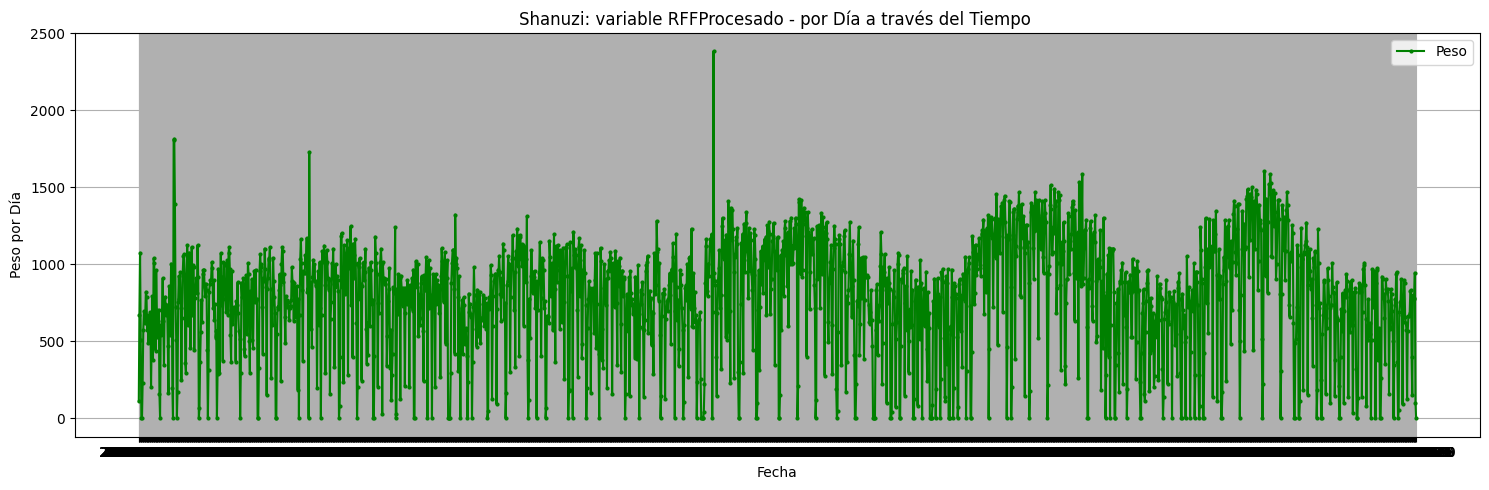

In [201]:
function_tendencia_unica(df_analisis_participacion,'RFFProcesado')

In [172]:
df_analisis_participacion.columns

Index(['pk_tiempo', 'vch_centro', 'SEDE', 'RFFProcesado',
       'RFFProcesadoPropios', 'RFFProcesadoTerceros', 'CPOObtenido',
       'CPOObtenidoPropios', 'CPOObtenidoTerceros', 'FECHA', 'PLANTACION',
       'SEMANA'],
      dtype='object')

In [202]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_participacion['FECHA'] = pd.to_datetime(df_analisis_participacion['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_participacion['SEMANA'] = df_analisis_participacion['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_participacion['MES'] = df_analisis_participacion['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)

# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_participacion_semana = df_analisis_participacion.groupby(['SEMANA','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                                   'RFFProcesadoPropios':'sum',
                                                                                                   'RFFProcesadoTerceros':'sum',
                                                                                                   'CPOObtenido':'sum',
                                                                                                   'CPOObtenidoPropios':'sum',
                                                                                                   'CPOObtenidoTerceros':'sum'}).reset_index()
df_analisis_participacion_semana.columns = ['FECHA', 'PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenido', 'CPOObtenidoPropios','CPOObtenidoTerceros']

# Agrupar por 'MES' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_participacion_mes = df_analisis_participacion.groupby(['MES','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                             'RFFProcesadoPropios':'sum',
                                                                                             'RFFProcesadoTerceros':'sum',
                                                                                             'CPOObtenido':'sum',
                                                                                             'CPOObtenidoPropios':'sum',
                                                                                             'CPOObtenidoTerceros':'sum'}).reset_index()
df_analisis_participacion_mes.columns = ['FECHA', 'PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenido', 'CPOObtenidoPropios',
       'CPOObtenidoTerceros']

df_analisis_participacion_mes.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21656\1656452725.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_participacion['FECHA'] = pd.to_datetime(df_analisis_participacion['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21656\1656452725.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_participacion['SEMANA'] = df_analisis_participacion['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21656\165

,FECHA,PLANTACION,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,CPOObtenidoPropios,CPOObtenidoTerceros
0,2019-01-01,Shanuzi,17623.41,17270.320,353.090,4426.248,4337.56687,88.68113
1,2019-02-01,Shanuzi,18851.15,18713.680,137.470,4828.749,4793.53586,35.21314
2,2019-03-01,Shanuzi,21927.21,21684.270,242.940,5410.679,5350.73202,59.94698
3,2019-04-01,Shanuzi,21835.93,21522.480,313.450,5476.600,5397.98461,78.61539
4,2019-05-01,Shanuzi,22580.32,22378.466,201.854,5941.648,5888.53335,53.11465


Analisis de  2018-12-31 00:00:00  hasta  2024-06-24 00:00:00


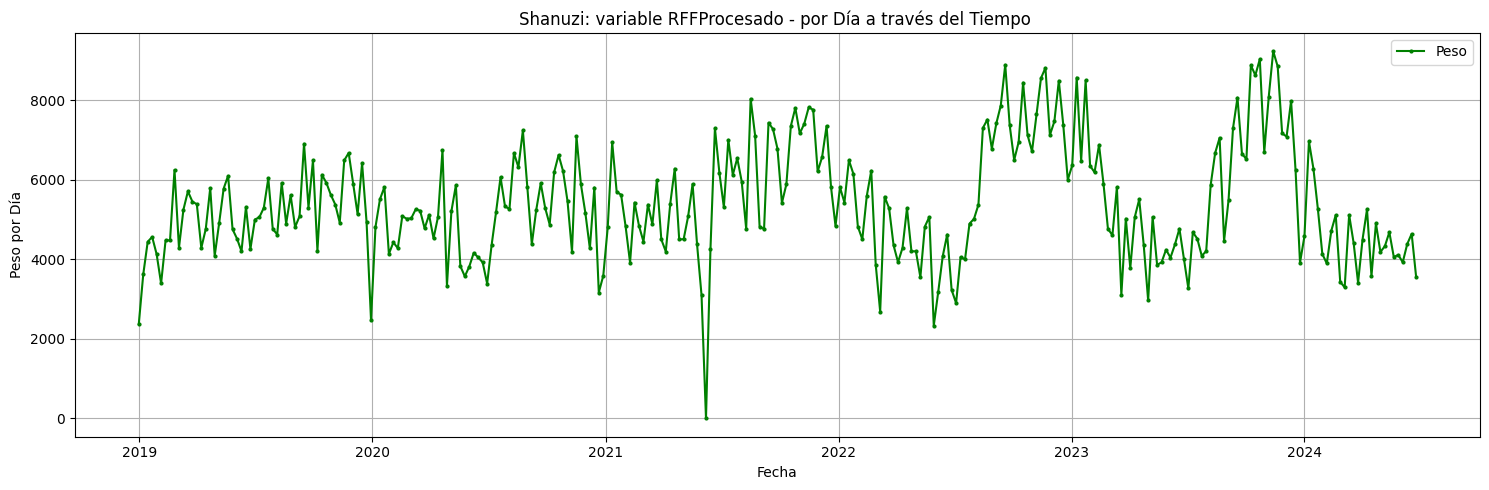

In [204]:
function_tendencia_unica(df_analisis_participacion_semana,'RFFProcesado')

In [190]:
# Mostrando el % de participacion
# ---
df_analisis_participacion_mes['Propios_Porcentaje'] = df_analisis_participacion_mes['RFFProcesadoPropios'] / df_analisis_participacion_semana['RFFProcesado'] * 100
df_analisis_participacion_mes['Terceros_Porcentaje'] = df_analisis_participacion_mes['RFFProcesadoTerceros'] / df_analisis_participacion_semana['RFFProcesado'] * 100
df_analisis_participacion_mes.head()

,FECHA,PLANTACION,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,CPOObtenidoPropios,CPOObtenidoTerceros,Propios_Porcentaje,Terceros_Porcentaje
0,2019-01-01,Palmawasi,27863.78,24921.10,2942.68,6865.27,6140.23223,725.03777,672.478183,79.406130
1,2019-02-01,Palmawasi,20839.85,18299.72,2540.13,5295.81,4650.31372,645.49628,313.384103,43.499920
2,2019-03-01,Palmawasi,23791.94,21271.85,2520.09,5869.24,5247.55831,621.68169,273.088196,32.352937
3,2019-04-01,Palmawasi,23637.04,21208.08,2428.96,5800.77,5204.67854,596.09146,312.604819,35.802609
4,2019-05-01,Palmawasi,21613.29,19461.61,2151.68,5433.97,4892.99892,540.97108,337.528855,37.317266


In [196]:
df_analisis_participacion_mes['Fecha_cat'] = df_analisis_participacion_mes['FECHA'].astype('object')
df_analisis_participacion_mes.head()

,FECHA,PLANTACION,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,CPOObtenidoPropios,CPOObtenidoTerceros,Propios_Porcentaje,Terceros_Porcentaje,Fecha_cat
0,2019-01-01,Palmawasi,27863.78,24921.10,2942.68,6865.27,6140.23223,725.03777,672.478183,79.406130,2019-01-01 00:00:00
1,2019-02-01,Palmawasi,20839.85,18299.72,2540.13,5295.81,4650.31372,645.49628,313.384103,43.499920,2019-02-01 00:00:00
2,2019-03-01,Palmawasi,23791.94,21271.85,2520.09,5869.24,5247.55831,621.68169,273.088196,32.352937,2019-03-01 00:00:00
3,2019-04-01,Palmawasi,23637.04,21208.08,2428.96,5800.77,5204.67854,596.09146,312.604819,35.802609,2019-04-01 00:00:00
4,2019-05-01,Palmawasi,21613.29,19461.61,2151.68,5433.97,4892.99892,540.97108,337.528855,37.317266,2019-05-01 00:00:00


In [205]:
function_save(df_analisis_participacion_mes)

Datos guardados en C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_001_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx


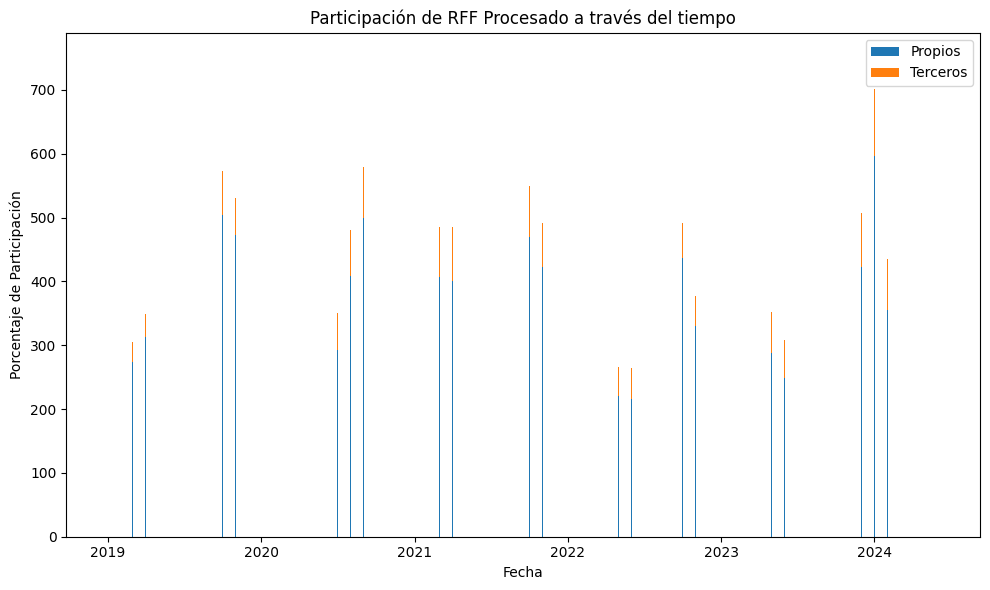

In [197]:
# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Ajuste del ancho de las barras
# Graficar barras apiladas
ax.bar(df_analisis_participacion_mes['Fecha_cat'], df_analisis_participacion_mes['Propios_Porcentaje'],  label='Propios')
ax.bar(df_analisis_participacion_mes['Fecha_cat'], df_analisis_participacion_mes['Terceros_Porcentaje'], bottom=df_analisis_participacion_mes['Propios_Porcentaje'], label='Terceros')

# Etiquetas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Porcentaje de Participación')
ax.set_title('Participación de RFF Procesado a través del tiempo')
ax.legend()

# Mostrar gráfico
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

##### OTRO ANALISIS

In [ ]:
# Analizando datos por Plantacion
# ----
df_TEA_full_tendencia = df_calidad_racimos_propios_full_group[df_calidad_racimos_propios_full_group['PLANTACION'] == 'Palmawasi']
# ---
df_TEA_full_tendencia = df_TEA_full_tendencia[df_TEA_full_tendencia['SECTOR'] == 'SE03']
# ---

function_tendencia_unica(df_TEA_full_tendencia,'Peso')

In [ ]:
df_TEA_full.head()

In [ ]:
print(df_TEA_full['PLANTACION'].unique())
df_TEA_full.head()

In [ ]:
function_tendencia_unica(df_TEA_full[df_TEA_full['PLANTACION'] == 'Nuevo Horizonte'], 'PROPIOS')

In [ ]:
# Filtramos la tendencia de interes DE LA BBDD UNIDA
# ################
# ################
# ################

# ---
df_TEA_full_tendencia = df_TEA_full[df_TEA_full['PLANTACION'] == 'Nuevo Horizonte']
df_TEA_full_tendencia = df_TEA_full_tendencia.sort_values(by='FECHA')
# ---

plantacion_name = df_TEA_full_tendencia['PLANTACION'].unique()

# Crear el gráfico de líneas para 'toneladas_dia'
plt.figure(figsize=(15, 5))
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO'], marker='o', markersize=2, linestyle='-', color='green', label='CPO OBTENIDO')
plt.title('RFF Procesado por Día a través del Tiempo - '+ plantacion_name[0])
plt.xlabel('Fecha')
plt.ylabel('RFF Procesado por Día')
plt.grid(True)
plt.legend()
#plt.xticks(rotation=45)

# Mostrar la gráfica
# print(df_TEA_full_tendencia[df_TEA_full_tendencia['RFF PROCESADO'] == 0].head())
plt.tight_layout()
plt.show()

In [ ]:
# ---
plantacion_name = df_TEA_full_tendencia['PLANTACION'].unique()


# Configurar el gráfico
plt.figure(figsize=(15, 5))

# Graficar 'VALOR1' y 'VALOR2'
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['RFF PROCESADO'], marker='o', markersize=4, label='RFF PROCESADO')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO'], marker='o', markersize=4, label='CPO OBTENIDO')

# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PROPIOS'], marker='o', markersize=4, label='PROPIOS')
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['TERCEROS'], marker='o', markersize=4, label='TERCEROS')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PRECIPITACION_TOTAL'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Comparación de RFF PROCESADO y CPO OBTENIDO a lo largo del tiempo - '+ plantacion_name[0])
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [ ]:
# Duplicando informacion faltante
# -----
df_TEA_full_tendencia_recorte = df_TEA_full_tendencia[['FECHA','CPO OBTENIDO']]
df_TEA_full_tendencia_recorte = df_TEA_full_tendencia_recorte.dropna(subset=['CPO OBTENIDO'])
df_TEA_full_tendencia_recorte = df_TEA_full_tendencia_recorte[df_TEA_full_tendencia_recorte['FECHA'] <= '2023-12-31']
# Lista de años a los que quieres copiar los datos
years_to_fill = [2019, 2020, 2021, 2022]

dfs_real = df_TEA_full_tendencia[['FECHA','CPO OBTENIDO']][df_TEA_full_tendencia['FECHA'] > '2023-01-01']

dfs = []
for year in years_to_fill:
    df_copy = df_TEA_full_tendencia_recorte.copy()
    # Ajustar el año mientras se maneja el caso especial del 29 de febrero
    def replace_year(date):
        try:
            return date.replace(year=year)
        except ValueError:
            # Manejar el 29 de febrero para años no bisiestos
            return date.replace(year=year, day=28)
    
    df_copy['FECHA'] = df_copy['FECHA'].apply(replace_year)
    dfs.append(df_copy)

# Concatenar todos los DataFrames
df_combined = pd.concat(dfs, ignore_index=True)
df_final = pd.concat([df_combined,dfs_real], ignore_index=True)

df_final.columns = ['FECHA','CPO OBTENIDO imp']
df_final.head()

In [ ]:
# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full_tendencia = pd.merge(df_TEA_full_tendencia,
                                 df_final, 
                                 on='FECHA', 
                                 how='left')

In [ ]:
df_TEA_full_tendencia.head()

In [ ]:
plantacion_name = df_TEA_full_tendencia['PLANTACION'].unique()


# Configurar el gráfico
plt.figure(figsize=(15, 5))

# Graficar 'VALOR1' y 'VALOR2'
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['RFF PROCESADO'], marker='o', markersize=4, label='RFF PROCESADO')
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO'], marker='o', markersize=4, label='CPO OBTENIDO')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO imp'], marker='o', markersize=4, label='CPO OBTENIDO imp')


# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PROPIOS'], marker='o', markersize=4, label='PROPIOS')
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['TERCEROS'], marker='o', markersize=4, label='TERCEROS')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PRECIPITACION_TOTAL'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Comparación de RFF PROCESADO y CPO OBTENIDO a lo largo del tiempo - '+ plantacion_name[0])
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

#### Agrupando por semanas

In [ ]:
# Crear columna 'SEMANA' que indica el año y la semana del año
df_TEA_full_tendencia['SEMANA'] = df_TEA_full_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_TEA_full_tendencia.head()

In [ ]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_TEA_full_semana = df_TEA_full_tendencia.groupby(['SEMANA', 'PLANTACION']).agg({'PROPIOS': 'sum',
                                                                                  'TERCEROS': 'sum',
                                                                                  'TOTAL': 'sum',
                                                                                  'RFF PROCESADO': 'sum',
                                                                                  'CPO OBTENIDO': 'sum',
                                                                                  'CPO OBTENIDO imp': 'sum',
                                                                                  'PRECIPITACION_TOTAL':'sum'}).reset_index()

df_TEA_full_semana.head()

#### Suavizando por medias moviles

In [ ]:
# Filtramos la tendencia de interes
# -------------

# ---
df_TEA_full_semana_tendencia = df_TEA_full_semana
df_TEA_full_semana_tendencia = df_TEA_full_semana_tendencia.sort_values(by='SEMANA')
df_TEA_full_semana_tendencia.head()

In [ ]:
# Suavizando por medias moviles
# ----------
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_2'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=2).mean() # Suavizado a 2 periodos
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=3).mean() # Suavizado a 3 periodos
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_4'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=4).mean() # Suavizado a 4 periodos
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_5'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=5).mean() # Suavizado a 5 periodos


df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_2'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=3).mean() # Suavizado a 3 periodos
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_4'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=4).mean() # Suavizado a 4 periodos
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_5'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=5).mean() # Suavizado a 5 periodos


# Probando traslaciones temporales
# -----------

# Desplazar 'VARIABLE_1' un período hacia adelante
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_1'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-1)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_2'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-2)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_3'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-3)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_4'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-4)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_5'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-5)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-6)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_7'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-7)


df_TEA_full_semana_tendencia.head()

In [ ]:
# Graficamos tendencias
# -------
# -----
# --

plantacion_name = df_TEA_full_semana_tendencia['PLANTACION'].unique()

# Crear el gráfico de líneas para 'toneladas_dia'
plt.figure(figsize=(15, 5))
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO imp'], marker='o', markersize=2, linestyle='-', color='green', label='CPO OBTENIDO')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_2'], marker='o', markersize=2, linestyle='-', color='red', label='CPO OBTENIDO_svzdo_2')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'], marker='o', markersize=2, linestyle='-', color='blue', label='CPO OBTENIDO_svzdo_3')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_4'], marker='o', markersize=2, linestyle='-', color='red', label='CPO OBTENIDO_svzdo_4')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_5'], marker='o', markersize=2, linestyle='-', color='blue', label='CPO OBTENIDO_svzdo_5')

plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_4'], marker='o', markersize=2, linestyle='-', color='blue', label='PRECIPITACION_TOTAL_SHIFTED_1')


plt.title('RFF Procesado por Semana a través del Tiempo - '+ plantacion_name[0])
plt.xlabel('Semana')
plt.ylabel('RFF Procesado por Semana')
plt.grid(True)
plt.legend()
#plt.xticks(rotation=45)

# Mostrar la gráfica
# print(df_TEA_full_semana_tendencia[df_TEA_full_semana_tendencia['RFF PROCESADO'] == 0].head())
plt.tight_layout()
plt.show()

In [ ]:
plantacion_name = df_TEA_full_semana_tendencia['PLANTACION'].unique()

# Configurar el gráfico
plt.figure(figsize=(15, 5))

# Graficar 'VALOR1' y 'VALOR2'
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['RFF PROCESADO'], marker='o', markersize=4, label='RFF PROCESADO')
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO imp'], marker='o', markersize=4, label='CPO OBTENIDO imp')

# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['TOTAL'], marker='o', markersize=4, label='TOTAL recibido')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PROPIOS'], marker='o', markersize=4, label='PROPIOS')
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_4'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Comparación de CPO OBTENIDO y PRECIPITACION_TOTAL a lo largo del tiempo - '+ plantacion_name[0])
plt.legend()

# Mostrar el gráfico
# Mostrar la gráfica
# print(df_TEA_full_semana_tendencia.head())
plt.grid(True)
plt.show()

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'], method='pearson')
correlation_spearman = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'], method='spearman')
correlation_kendall = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], method='pearson')
correlation_spearman = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], method='spearman')
correlation_kendall = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'], method='pearson')
correlation_spearman = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'], method='spearman')
correlation_kendall = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)

In [ ]:
from statsmodels.tsa.stattools import coint

# Suponiendo que series1 y series2 son tus series temporales
score, p_value, _ = coint(df_TEA_full_semana_tendencia['CPO OBTENIDO imp'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_5'])

print("P-valor de la cointegración:", p_value)

In [ ]:
import statsmodels.api as sm


In [ ]:
import statsmodels.api as sm

# Suponiendo que df tiene 'X' como variable independiente y 'Y' como variable dependiente
X = df_TEA_full_semana_tendencia[['PRECIPITACION_TOTAL_svzdo_3']]
Y = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3']
X = sm.add_constant(X)  # Añadir constante para la intercepción
model = sm.OLS(Y, X).fit()
print(model.summary())

#### Transformando data por Plantación

##### Planta Shanuzi

In [ ]:

print(df_TEA_full.FECHA.min())
print(df_TEA_full.FECHA.max())
print(df_TEA_full[df_TEA_full['PLANTACION'] == 'Shanuzi'].head())

print(df_sabana_saldo_campo_full_vf.FECHA.min())
print(df_sabana_saldo_campo_full_vf.FECHA.max())
print(df_sabana_saldo_campo_full_vf[df_sabana_saldo_campo_full_vf['PLANTACION'] == 'Shanuzi'].head())

In [ ]:
# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full_sh = pd.merge(df_TEA_full[df_TEA_full['PLANTACION'] == 'Shanuzi'],
                          df_sabana_saldo_campo_full_vf[df_sabana_saldo_campo_full_vf['PLANTACION'] == 'Shanuzi'],
                          on=['FECHA', 'PLANTACION'], how='inner')
# Convertir 'FECHA' a formato datetime
df_TEA_full_sh['FECHA'] = pd.to_datetime(df_TEA_full_sh['FECHA'])
df_TEA_full_sh.head(10)

In [ ]:
# Crear columna 'SEMANA' que indica el año y la semana del año
df_TEA_full_sh['SEMANA'] = df_TEA_full_sh['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_TEA_full_sh.head()

In [ ]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_TEA_full_sh_semana = df_TEA_full_sh.groupby(['SEMANA', 'PLANTACION']).agg({'PROPIOS': 'sum',
                                                                              'TERCEROS': 'sum',
                                                                              'TOTAL': 'sum',
                                                                              'RFF PROCESADO': 'sum',
                                                                              'CPO OBTENIDO': 'sum',
                                                                              'SALDO':'mean',
                                                                              'SALDO > 3':'mean',
                                                                              'PRECIPITACION_TOTAL':'sum'}).reset_index()

df_TEA_full_sh_semana.head()

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

# Graficar la primera variable en el eje principal
ax1.plot(df_TEA_full_sh_semana['SEMANA'], df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_TEA_full_sh_semana['SEMANA'], df_TEA_full_sh_semana['CPO OBTENIDO'], color='green', marker='s', linestyle='--', label='CPO OBTENIDO')
ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle('Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_sh_semana['CPO OBTENIDO'].corr(df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], method='pearson')
correlation_spearman = df_TEA_full_sh_semana['CPO OBTENIDO'].corr(df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], method='spearman')
correlation_kendall = df_TEA_full_sh_semana['CPO OBTENIDO'].corr(df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)